In [ ]:
# Imports
import requests
import pandas as pd
from datetime import datetime, timedelta
from datetime import date as dt_date
from requests.exceptions import ReadTimeout, ConnectionError, RequestException

import time
import json

In [23]:
def fmt(val):
    return f"${val:,.2f}"

In [24]:
from dotenv import load_dotenv
import os

load_dotenv()

STOCK_API_KEY = os.getenv("POLYGON_STOCK_API_KEY")
OPTIONS_API_KEY = os.getenv("POLYGON_OPTIONS_API_KEY")


index = 'SPY'  # Index proxy

# Strategy config
DTE_TARGET = 60
DTE_TOLERANCE = 5  # days
MAX_VEGA_DRIFT = 0.15  # ±10%
MAX_DELTA_DRIFT = 0.15    # ±10% delta (per 1 underlying), tweak as you like
PREFERRED_MIN_MONTH = (2025, 9)   # (year, month) — NOT a fixed day



In [25]:
# Load the Excel file
delta_df = pd.read_excel("New_Bloomberg_Delta.xlsx", sheet_name="Values")

# Identify metadata columns
meta_cols = ['Polygon Ticker', 'Bloomberg Ticker Equity']

# Manually detect date columns by checking if they can be parsed to datetime
date_cols = []
for col in delta_df.columns:
    if col not in meta_cols:
        try:
            _ = pd.to_datetime(col)
            date_cols.append(col)
        except:
            continue

# Melt the DataFrame using only date columns
delta_long = delta_df.melt(
    id_vars=['Polygon Ticker'],
    value_vars=date_cols,
    var_name='Date',
    value_name='Delta'
)

# Convert the date strings to actual datetime.date objects
delta_long['Date'] = pd.to_datetime(delta_long['Date'], errors='coerce').dt.date

# Drop rows where date conversion failed
delta_long = delta_long.dropna(subset=['Date'])

# Make sure the values are numeric (coerce blanks/strings to NaN)
delta_long['Delta'] = pd.to_numeric(delta_long['Delta'], errors='coerce')

# Ensure no duplicate (Ticker, Date) pairs
delta_long = delta_long.drop_duplicates(subset=['Polygon Ticker', 'Date'])

# Create lookup
delta_lookup = delta_long.set_index(['Polygon Ticker', 'Date'])
delta_lookup.head(10)


,,Delta
Polygon Ticker,Date,
O:SPY250919C00615000,2025-06-23,0.439
O:SPY250919P00615000,2025-06-23,-0.594
O:MSFT250919C00495000,2025-06-23,0.490
O:MSFT250919P00495000,2025-06-23,-0.523
O:AAPL250919C00200000,2025-06-23,0.577
O:AAPL250919P00200000,2025-06-23,-0.432
O:NVDA250919C00158000,2025-06-23,0.374
O:NVDA250919P00158000,2025-06-23,-0.635
O:V250919C00350000,2025-06-23,0.488


In [26]:
# Load the Excel file
vega_df = pd.read_excel("New_Bloomberg_Vega.xlsx")

# Identify metadata columns
meta_cols = ['Underlying Ticker', 'Polygon Ticker', 'Bloomberg Ticker', 'Bloomberg Ticker Equity']

# Manually detect date columns by checking if they can be parsed to datetime
date_cols = []
for col in vega_df.columns:
    if col not in meta_cols:
        try:
            parsed = pd.to_datetime(col)
            date_cols.append(col)
        except:
            continue

# Melt the DataFrame using only date columns
vega_long = vega_df.melt(
    id_vars=['Polygon Ticker'],
    value_vars=date_cols,
    var_name='Date',
    value_name='Vega'
)

# Convert the date strings to actual datetime.date objects
vega_long['Date'] = pd.to_datetime(vega_long['Date'], errors='coerce').dt.date

# Drop rows where date conversion failed
vega_long = vega_long.dropna(subset=['Date'])

# Ensure no duplicate (Ticker, Date) pairs
vega_long = vega_long.drop_duplicates(subset=['Polygon Ticker', 'Date'])

# Create lookup
vega_lookup = vega_long.set_index(['Polygon Ticker', 'Date'])
vega_lookup.head(10)

,,Vega
Polygon Ticker,Date,
O:SPY250919C00615000,2025-06-23,1.173
O:SPY250919P00615000,2025-06-23,1.131
O:MSFT250919C00495000,2025-06-23,0.961
O:MSFT250919P00495000,2025-06-23,0.952
O:AAPL250919C00200000,2025-06-23,0.391
O:AAPL250919P00200000,2025-06-23,0.391
O:NVDA250919C00158000,2025-06-23,0.271
O:NVDA250919P00158000,2025-06-23,0.267
O:V250919C00350000,2025-06-23,0.678


In [ ]:
def get_spot_price(ticker, reference_date=None):
    if reference_date:
        date_str = pd.to_datetime(reference_date).strftime("%Y-%m-%d")
        url = f"https://api.polygon.io/v1/open-close/{ticker}/{date_str}?adjusted=true&apiKey={STOCK_API_KEY}"
        # print(f"[SPOT] Requesting historical price: {url}")
        try:
            res = requests.get(url, timeout=10)  # ⏱ 10s timeout
            data = res.json()
        except (ReadTimeout, ConnectionError) as e:
            print(f"⏰ Timeout fetching spot for {ticker} on {date_str}: {e}")
            return None
        except RequestException as e:
            print(f"⚠️ Request error for spot {ticker} on {date_str}: {e}")
            return None

        if res.status_code == 200 and 'close' in data:
            return data['close']
        else:
            print(f"⚠️ Historical fallback failed for {ticker} on {date_str}. Response: {data}")
            return None
    else:
        url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/prev?adjusted=true&apiKey={STOCK_API_KEY}"
        try:
            res = requests.get(url, timeout=10)
            data = res.json()
        except (ReadTimeout, ConnectionError) as e:
            print(f"⏰ Timeout fetching prev close for {ticker}: {e}")
            return None
        except RequestException as e:
            print(f"⚠️ Request error for prev close {ticker}: {e}")
            return None

        if 'results' in data and len(data['results']) > 0:
            return data['results'][0]['c']
        print(f"[SPOT] Fallback response for {ticker}: {data}")
        return None


    
def format_option(opt):
    if not opt:
        return "None"
    return (
        f"{opt['ticker']} | Strike: {opt['strike_price']} | "
        f"Exp: {opt['expiration_date']} | Type: {opt['contract_type']} | "
        f"Exercise: {opt['exercise_style']} | Multiplier: {opt.get('multiplier', 'N/A')}"
    )




In [28]:
import pandas_market_calendars as mcal
from datetime import datetime, timedelta

def get_nearest_valid_friday(start_date=None, max_shift=10):
    if start_date is None:
        start_date = datetime.utcnow().date()

    nyse = mcal.get_calendar('NYSE')

    for delta in range(max_shift + 1):
        for direction in [1, -1]:
            check_date = start_date + timedelta(days=delta * direction)
            if check_date.weekday() == 4:  # Friday
                schedule = nyse.schedule(start_date=check_date, end_date=check_date)
                if not schedule.empty:
                    return check_date.strftime('%Y-%m-%d')
    return None

def get_atm_call_put_contracts(ticker, target_dte, reference_date=None):
    spot = get_spot_price(ticker, reference_date)
    if spot is None:
        print(f"❌ Could not fetch spot price for {ticker}")
        return None, None

    if reference_date is None:
        reference_date = datetime.utcnow().date()
    else:
        reference_date = pd.to_datetime(reference_date).date()

    target_expiry = reference_date + timedelta(days=target_dte)
    expiry = get_nearest_valid_friday(target_expiry)
    #print(f"Nearest expiry: {expiry}")

    def get_atm_option(ticker, expiry, contract_type):
        url = (
            f"https://api.polygon.io/v3/reference/options/contracts?"
            f"underlying_ticker={ticker}&contract_type={contract_type}"
            f"&expiration_date={expiry}&as_of={reference_date}"
            f"&limit=500&apiKey={OPTIONS_API_KEY}"
        )
        print(f"[ATM] Requesting: {url}")
        res = requests.get(url)
        data = res.json()
        options = data.get("results", [])
        if not options:
            print(f"⚠️ No {contract_type} options for {ticker} at {expiry} as of {reference_date}")
            return None
        return min(options, key=lambda c: abs(c['strike_price'] - spot), default=None)

    atm_call = get_atm_option(ticker, expiry, 'call')
    atm_put = get_atm_option(ticker, expiry, 'put')

    def fmt(o):
        if not o: return "None"
        return (f"{o['ticker']} | Strike: {o['strike_price']} | Exp: {o['expiration_date']} | "
                f"Type: {o['contract_type']} | Exercise: {o['exercise_style']}")

    #print(atm_call['ticker'])
    #print(atm_put['ticker'])
    print(f"✅ ATM Call: {fmt(atm_call)}")
    print(f"✅ ATM Put: {fmt(atm_put)}")
    return atm_call, atm_put


In [ ]:
def get_trading_days_window(reference_date, back=5, forward=2):
    """
    Returns a list of trading days: 5 before + 2 after the reference date (business days only).
    """
    nyse = mcal.get_calendar('NYSE')
    start = pd.to_datetime(reference_date) - pd.Timedelta(days=10)
    end = pd.to_datetime(reference_date) + pd.Timedelta(days=5)
    schedule = nyse.schedule(start_date=start, end_date=end)
    trading_days = list(schedule.index.date)

    ref = pd.to_datetime(reference_date).date()
    past = [d for d in trading_days if d <= ref][-back:]
    future = [d for d in trading_days if d > ref][:forward]
    return past[::-1] + future  # most recent past first, then future

def get_option_greeks(underlying_ticker, option_symbol, reference_date=None):
    """
    Get vega, delta (from Excel where possible) and price (from Polygon).
    - Uses Excel vega/delta when available
    - Uses Polygon open/close (±5/2 trading days) for price
    - Handles timeouts + request errors gracefully
    - Returns None if we cannot get BOTH price and vega
    """
    vega = None
    delta = None
    price = None

    # -------- Step 1: Vega from Excel --------
    if reference_date:
        try:
            date_obj = pd.to_datetime(reference_date).date()
            vega = vega_lookup.loc[(option_symbol, date_obj), 'Vega']
        except KeyError:
            # print(f"⚠️ Vega not found for {option_symbol} on {reference_date}")
            pass

    # -------- Step 1b: Delta from Excel --------
    if reference_date:
        try:
            date_obj = pd.to_datetime(reference_date).date()
            delta = delta_lookup.loc[(option_symbol, date_obj), 'Delta']
        except KeyError:
            # print(f"⚠️ Delta not found for {option_symbol} on {reference_date}")
            pass

    # -------- Step 2: Price from Polygon --------
    if reference_date:
        days_to_try = get_trading_days_window(reference_date, back=5, forward=2)
        for day in days_to_try:
            date_str = day.strftime('%Y-%m-%d')
            url = (
                f"https://api.polygon.io/v1/open-close/"
                f"{option_symbol}/{date_str}?adjusted=true&apiKey={OPTIONS_API_KEY}"
            )
            # print(f"[PRICE] Trying {date_str} for {option_symbol}")
            try:
                res = requests.get(url, timeout=10)  # ⏱ 10s timeout
                data = res.json()
            except (ReadTimeout, ConnectionError) as e:
                print(f"⏰ Timeout fetching {option_symbol} on {date_str}: {e}")
                continue
            except RequestException as e:
                print(f"⚠️ Request error for {option_symbol} on {date_str}: {e}")
                continue

            time.sleep(0.2)  # keep your rate limiting

            if res.status_code == 200 and 'close' in data:
                price = data['close']
                break

        if price is None:
            print(f"❌ No price found for {option_symbol} ±5/2 trading days (timeout or missing data)")

    else:
        # No reference date: use live snapshot (less relevant for your backtest, but keep it)
        url = f"https://api.polygon.io/v3/snapshot/options/{underlying_ticker}/{option_symbol}?apiKey={OPTIONS_API_KEY}"
        try:
            res = requests.get(url, timeout=10)
            data = res.json()
        except (ReadTimeout, ConnectionError) as e:
            print(f"⏰ Timeout fetching snapshot for {option_symbol}: {e}")
            data = {}
        except RequestException as e:
            print(f"⚠️ Request error for snapshot {option_symbol}: {e}")
            data = {}

        if res.status_code == 200 and 'results' in data:
            price = data['results']['day']['close']
            greeks = data['results'].get('greeks', {}) or {}
            if vega is None:
                vega = greeks.get('vega')
            if delta is None:
                delta = greeks.get('delta')

    # -------- Step 3: Validate and return --------
    if price is None or vega is None:
        # print(f"⚠️ Incomplete data for {option_symbol}, skipping.")
        return None

    try:
        vega = float(vega)
    except Exception:
        vega = None

    if vega is None:
        return None

    if delta is not None:
        try:
            delta = float(delta)
        except Exception:
            delta = None

    return {
        'symbol': option_symbol,
        'vega': vega,
        'delta': delta,
        'price': float(price),
        'underlying': underlying_ticker
    }

In [30]:
def print_holdings(positions):
    print("📊 Current Holdings:")
    for p in positions:
        vega_now  = p.get('vega_today', p.get('vega', 0)) or 0
        delta_now = p.get('delta_today', p.get('delta', 0)) or 0

        signed_vega  = vega_now  * p['quantity'] * (1 if p['type']=='long' else -1)
        signed_delta = delta_now * p['quantity'] * (1 if p['type']=='long' else -1)

        initial_price = p['price']
        current_price = p.get('price_today', initial_price) or initial_price
        quantity = p['quantity']

        total_cost = initial_price * quantity
        current_value = current_price * quantity
        pnl = current_value - total_cost
        pnl_pct = (pnl / total_cost * 100) if total_cost != 0 else 0

        print(f"  {p['type'].upper():<6} {p['ticker']} ({p['underlying']}) | "
              f"Vega: {signed_vega:+.4f}  Delta: {signed_delta:+.4f} | "
              f"Price: {fmt(initial_price)} | Today: {fmt(current_price)} | "
              f"Qty: {quantity:.4f} | Cost: {fmt(total_cost)} | PnL: {fmt(pnl)} ({pnl_pct:.2f}%)")


In [ ]:
# Initialize an empty list to store daily PnL records
pnl_log = []
positions_log = []

def calculate_daily_pnl_with_logging(positions, date):
    short_pnl = 0
    long_pnl = 0
    short_cost = 0
    long_cost = 0

    for p in positions:
        if 'vega_today' not in p or 'price_today' not in p:
            continue  # Skip if data is missing

        initial_price = p['price']
        current_price = p['price_today']
        quantity = p['quantity']

        trade_pnl = (current_price - initial_price) * quantity
        cost = initial_price * quantity

        if p['type'] == 'short':
            short_pnl -= trade_pnl
            short_cost += cost
        else:
            long_pnl += trade_pnl
            long_cost += cost

    total_pnl = short_pnl + long_pnl
    total_cost = short_cost + long_cost

    short_pct = (short_pnl / short_cost * 100) if short_cost != 0 else 0
    long_pct = (long_pnl / long_cost * 100) if long_cost != 0 else 0
    total_pct = (total_pnl / total_cost * 100) if total_cost != 0 else 0

    pnl_log.append({
        "date": pd.to_datetime(date),
        "short": short_pnl,
        "long": long_pnl,
        "total": total_pnl,
        "short_pct": short_pct,
        "long_pct": long_pct,
        "total_pct": total_pct
    })

    print(f"💰 PnL (Date: {date}):")
    print(f"   Short Leg: {fmt(short_pnl)} ({short_pct:.2f}%)")
    print(f"   Long  Leg: {fmt(long_pnl)} ({long_pct:.2f}%)")
    print(f"   Total     : {fmt(total_pnl)} ({total_pct:.2f}%)")





In [32]:
import copy

positions_log = []

def log_positions_for_date(positions, current_date):
    for p in positions:
        positions_log.append({
            "date": pd.to_datetime(current_date),
            "ticker": p["ticker"],
            "underlying": p["underlying"],
            "type": p["type"],
            "quantity": float(p["quantity"]),
            "price": float(p.get("price", 0) or 0),
            "price_today": float(p.get("price_today", p.get("price", 0)) or 0),
            "delta": float(p.get("delta_today", p.get("delta", 0)) or 0),
            "vega": float(p.get("vega_today", p.get("vega", 0)) or 0),
        })


In [33]:
def check_vega_imbalance(positions):
    net_vega = sum(
        (p['vega_today'] or 0) * p['quantity'] * (1 if p['type'] == 'long' else -1)
        for p in positions
    )
    if abs(net_vega) > MAX_VEGA_DRIFT:
        print(f"⚠️ Vega imbalance detected! Net Vega: {net_vega:.4f}")
    else:
        print(f"✅ Vega within balance. Net Vega = {net_vega:.4f}")


In [34]:
def vega_hedge(positions, date):
    # Use the updated greeks cached in 'vega_today'
    net_vega = sum(
        (p.get('vega_today') or 0) * p['quantity'] * (1 if p['type'] == 'long' else -1)
        for p in positions
    )

    if abs(net_vega) <= MAX_VEGA_DRIFT:
        return

    # Find current SPY call and put positions
    spy_call = next((
        p for p in positions
        if p['underlying'] == 'SPY'
        and p['ticker'].startswith('O:SPY')
        and p['ticker'][11] == 'C'
    ), None)

    spy_put = next((
        p for p in positions
        if p['underlying'] == 'SPY'
        and p['ticker'].startswith('O:SPY')
        and p['ticker'][11] == 'P'
    ), None)

    if not spy_call or not spy_put:
        print("❌ Cannot find both SPY call and put to construct straddle.")
        return

    # 🔒 Skip hedging if close to expiry
    expiry_date = dt_date(2025, 9, 19)
    days_to_expiry = (expiry_date - date).days

    if days_to_expiry <= 3:
        print(f"⏸️ Skipping vega hedge (only {days_to_expiry} days to expiry)")
        return

    # Get current greeks for hedge decision
    call_greeks = get_option_greeks('SPY', spy_call['ticker'], reference_date=date)
    put_greeks  = get_option_greeks('SPY', spy_put['ticker'], reference_date=date)
    if not call_greeks or not put_greeks:
        print("❌ Failed to fetch SPY greeks.")
        return

    total_vega = call_greeks['vega'] + put_greeks['vega']
    print(f"⚖️ Net Vega: {net_vega:.4f}, SPY Straddle Vega: {total_vega:.4f}")

    if total_vega == 0:
        print("❌ SPY straddle has zero vega — cannot hedge.")
        return

    qty = -net_vega / total_vega
    action = "Buying" if qty > 0 else "Selling"
    print(f"🔄 Rebalancing: {action} {abs(qty):.2f}x SPY straddle to flatten vega.")

    for leg_greeks in [call_greeks, put_greeks]:
        positions.append({
            'ticker': leg_greeks['symbol'],
            'vega': leg_greeks['vega'],
            'vega_today': leg_greeks['vega'],
            'price': leg_greeks['price'],
            'quantity': abs(qty),
            'type': 'long' if qty > 0 else 'short',
            'underlying': 'SPY'
        })


In [35]:
def check_delta_imbalance(positions):
    net_delta = sum(
        (p.get('delta_today') or 0) * p['quantity'] * (1 if p['type'] == 'long' else -1)
        for p in positions
    )
    if abs(net_delta) > MAX_DELTA_DRIFT:
        print(f"⚠️ Delta imbalance detected! Net Delta: {net_delta:.4f}")
    else:
        print(f"✅ Delta within balance. Net Delta = {net_delta:.4f}")

In [36]:
def delta_hedge(positions, date, hedge_underlying="SPY"):
    # compute net delta (use today's greeks if present, else base delta)
    net_delta = 0.0
    for p in positions:
        d = p.get('delta_today')
        if d is None:
            d = p.get('delta', 0)
        sign = 1 if p['type'] == 'long' else -1
        net_delta += (d or 0) * p['quantity'] * sign

    if abs(net_delta) <= MAX_DELTA_DRIFT:
        return  # already balanced

    # find / update a single consolidated stock hedge line
    hedge_line = next((p for p in positions
                       if p.get('ticker') == f"{hedge_underlying}_HEDGE_STOCK"), None)

    spot = get_spot_price(hedge_underlying, reference_date=date)
    if spot is None:
        print(f"❌ Could not fetch spot for {hedge_underlying} to delta-hedge.")
        return

    # Target quantity: stock Δ = +1 per share. Use negative of net_delta to flatten.
    qty_to_target = -net_delta
    action = "BUY" if qty_to_target > 0 else "SELL"
    print(f"🔧 Delta hedge: {action} {abs(qty_to_target):.4f} {hedge_underlying} shares @ ~{fmt(spot)}")

    if hedge_line is None:
        positions.append({
            'ticker': f"{hedge_underlying}_HEDGE_STOCK",
            'vega': 0.0,
            'vega_today': 0.0,
            'delta': 1.0,
            'delta_today': 1.0,
            'price': spot,
            'price_today': spot,
            'quantity': abs(qty_to_target),
            'type': 'long' if qty_to_target > 0 else 'short',
            'underlying': hedge_underlying
        })
    else:
        # adjust existing hedge sizing + mark price_today
        hedge_line['quantity'] = abs(qty_to_target)
        hedge_line['type']     = 'long' if qty_to_target > 0 else 'short'
        hedge_line['price_today'] = spot
        hedge_line['delta_today'] = 1.0
        hedge_line['vega_today']  = 0.0

In [37]:
def build_vega_neutral_trade(start_date):
    index = "SPY"
    positions = []

    # Load optimized weights (reversed dispersion)
    portfolio_df = pd.read_excel("optimized_weights.xlsx")
    underlyings = portfolio_df["Ticker"].tolist()
    weights = portfolio_df["Optimized_Weight"].tolist()

    # Get ATM SPY straddle
    call, put = get_atm_call_put_contracts(index, target_dte=87, reference_date=start_date)
    if not call or not put:
        print("❌ Could not get SPY ATM straddle.")
        return []

    greeks_call = get_option_greeks(index, call['ticker'], reference_date=start_date)
    greeks_put = get_option_greeks(index, put['ticker'], reference_date=start_date)
    if not greeks_call or not greeks_put:
        print("❌ Could not get SPY greeks.")
        return []

    # Long index straddle (reverse dispersion)
    qty = 5
    positions.append({
        'ticker': greeks_call['symbol'],
        'vega': greeks_call['vega'],
        'price': greeks_call['price'],
        'quantity': qty,
        'type': 'long',
        'underlying': index
    })
    positions.append({
        'ticker': greeks_put['symbol'],
        'vega': greeks_put['vega'],
        'price': greeks_put['price'],
        'quantity': qty,
        'type': 'long',
        'underlying': index
    })

    total_long_vega = qty * (greeks_call['vega'] + greeks_put['vega'])

    # Allocate short straddles across stocks
    for stock, weight in zip(underlyings, weights):
        call, put = get_atm_call_put_contracts(stock, target_dte=87, reference_date=start_date)
        if not call or not put:
            print(f"⚠️ Skipping {stock}, missing contracts.")
            continue

        greeks_call = get_option_greeks(stock, call['ticker'], reference_date=start_date)
        greeks_put = get_option_greeks(stock, put['ticker'], reference_date=start_date)
        if not greeks_call or not greeks_put:
            print(f"⚠️ Skipping {stock}, missing greeks.")
            continue

        stock_vega = greeks_call['vega'] + greeks_put['vega']
        if stock_vega == 0:
            continue

        # Allocate based on weighted vega target
        target_vega = total_long_vega * weight
        scale = target_vega / stock_vega

        positions.append({
            'ticker': greeks_call['symbol'],
            'vega': greeks_call['vega'],
            'price': greeks_call['price'],
            'quantity': scale,
            'type': 'short',
            'underlying': stock
        })
        positions.append({
            'ticker': greeks_put['symbol'],
            'vega': greeks_put['vega'],
            'price': greeks_put['price'],
            'quantity': scale,
            'type': 'short',
            'underlying': stock
        })

    return positions


In [ ]:
def update_positions_for_date(positions, date):
    """
    Refresh greeks/price for each position on a given date.

    - For synthetic stock hedge lines (e.g. 'SPY_HEDGE_STOCK'):
        * Use get_spot_price for price_today
        * Force delta_today = 1.0, vega_today = 0.0

    - For normal option positions:
        * Try to get fresh greeks + price from get_option_greeks
        * If that fails (timeout, missing data), fall back to:
            - last known *_today values if they exist
            - otherwise base 'price', 'delta', 'vega'
    """
    for p in positions:
        ticker = p.get('ticker', '')

        # 🔹 Special case: synthetic stock hedge like "SPY_HEDGE_STOCK"
        if ticker.endswith('_HEDGE_STOCK'):
            spot = get_spot_price(p['underlying'], reference_date=date)
            if spot is None:
                print(f"⚠️ Could not fetch spot for hedge {ticker} on {date}, keeping last price.")
                # keep previous price_today if we have it; otherwise stick with original price
                if 'price_today' not in p or p['price_today'] is None:
                    p['price_today'] = p.get('price', None)
            else:
                p['price_today'] = spot
                # set base price if not already set
                if 'price' not in p or p['price'] is None:
                    p['price'] = spot

            # stock greeks: pure delta, no vega
            p['delta_today'] = 1.0
            p['vega_today']  = 0.0
            continue  # ✅ don't call get_option_greeks for hedge

        # 🔹 Normal options path: try to refresh from Excel + Polygon
        greeks = get_option_greeks(p['underlying'], p['ticker'], reference_date=date)

        if greeks is not None:
            # fresh data available
            p['vega_today']  = greeks['vega']
            p['delta_today'] = greeks['delta'] if greeks['delta'] is not None else p.get('delta', 0.0)
            p['price_today'] = greeks['price']
        else:
            # ❗ fallback: retain last known values, or base values if first day
            # Vega
            if 'vega_today' not in p or p['vega_today'] is None:
                p['vega_today'] = p.get('vega', 0.0)
            # Delta
            if 'delta_today' not in p or p['delta_today'] is None:
                p['delta_today'] = p.get('delta', 0.0)
            # Price
            if 'price_today' not in p or p['price_today'] is None:
                p['price_today'] = p.get('price', 0.0)


In [39]:
def build_delta_vega_neutral_trade(start_date):
    positions = build_vega_neutral_trade(start_date)  # your existing builder
    if not positions:
        return []

    # hydrate greeks at start_date
    update_positions_for_date(positions, start_date)

    # initial delta hedge (vega already balanced by design)
    check_delta_imbalance(positions)
    delta_hedge(positions, start_date)

    return positions


In [40]:
from datetime import date, timedelta
import pandas_market_calendars as mcal

# Backtest setup
print("📆 Starting Delta + Vega Neutral Dispersion Backtest...\n")

# Define start and end dates
start_date = date(2025, 6, 27)
end_date   = date(2025, 9, 18)

# Build initial delta + vega neutral portfolio
positions = build_delta_vega_neutral_trade(start_date)
print_holdings(positions)

# Get NYSE trading days
nyse = mcal.get_calendar('NYSE')
schedule = nyse.schedule(start_date=start_date, end_date=end_date)
valid_trading_days = set(schedule.index.date)

# Backtest loop — run daily updates, PnL logging, and hedging
current_date = start_date
while current_date <= end_date:
    if current_date in valid_trading_days:
        print(f"\n🗓️ Date: {current_date}")

        # Refresh option prices and greeks for the day
        update_positions_for_date(positions, current_date)

        # Compute and log daily PnL
        calculate_daily_pnl_with_logging(positions, current_date)

        # Check vega drift and rebalance if needed
        check_vega_imbalance(positions)
        vega_hedge(positions, current_date)

        # Check delta drift and hedge if needed
        check_delta_imbalance(positions)
        delta_hedge(positions, current_date)

        log_positions_for_date(positions, current_date)

        # Display current portfolio
        print_holdings(positions)
        print("-" * 60)

    # Move to next calendar day
    current_date += timedelta(days=1)


📆 Starting Delta + Vega Neutral Dispersion Backtest...

[SPOT] Requesting historical price: https://api.polygon.io/v1/open-close/SPY/2025-06-27?adjusted=true&apiKey=phX3UGTSILWy8uHUdxQauDRZF578YwRL
[ATM] Requesting: https://api.polygon.io/v3/reference/options/contracts?underlying_ticker=SPY&contract_type=call&expiration_date=2025-09-19&as_of=2025-06-27&limit=500&apiKey=phX3UGTSILWy8uHUdxQauDRZF578YwRL
[ATM] Requesting: https://api.polygon.io/v3/reference/options/contracts?underlying_ticker=SPY&contract_type=put&expiration_date=2025-09-19&as_of=2025-06-27&limit=500&apiKey=phX3UGTSILWy8uHUdxQauDRZF578YwRL
✅ ATM Call: O:SPY250919C00615000 | Strike: 615 | Exp: 2025-09-19 | Type: call | Exercise: american
✅ ATM Put: O:SPY250919P00615000 | Strike: 615 | Exp: 2025-09-19 | Type: put | Exercise: american
[SPOT] Requesting historical price: https://api.polygon.io/v1/open-close/MSFT/2025-06-27?adjusted=true&apiKey=phX3UGTSILWy8uHUdxQauDRZF578YwRL
[ATM] Requesting: https://api.polygon.io/v3/refere

ReadTimeout: HTTPSConnectionPool(host='api.polygon.io', port=443): Read timed out. (read timeout=None)

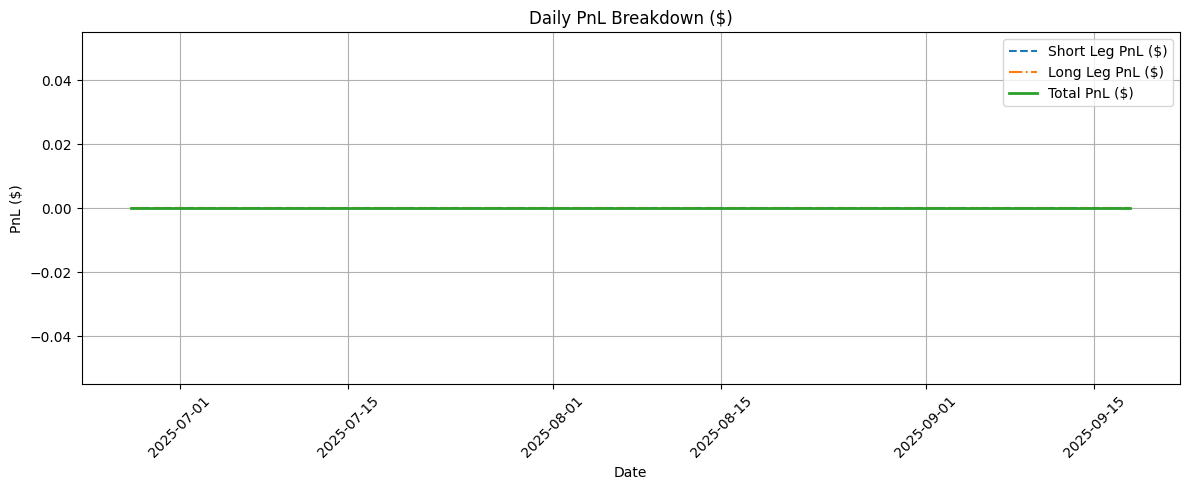

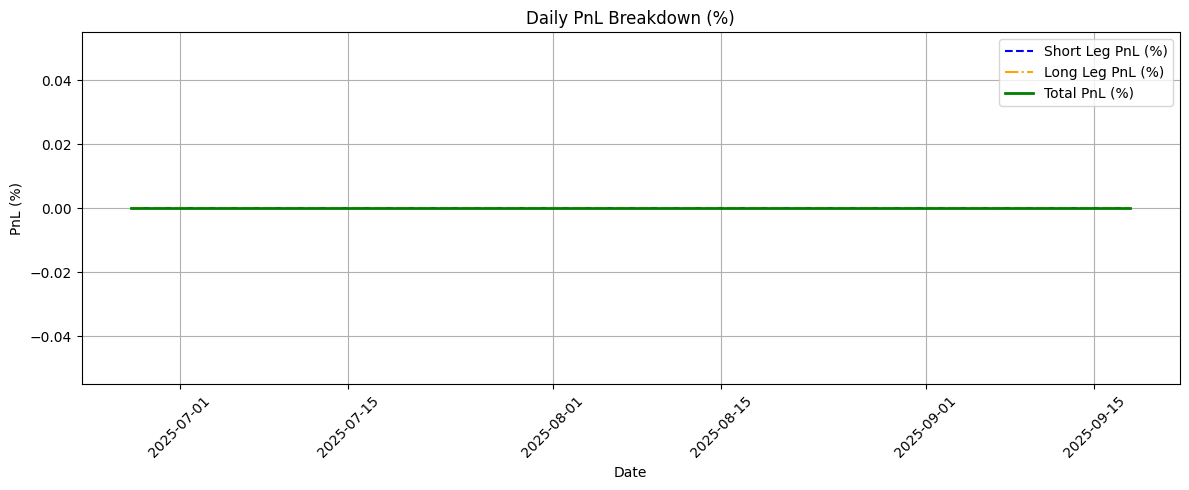

In [ ]:
from matplotlib import pyplot as plt

def plot_pnl_log():
    pnl_df = pd.DataFrame(pnl_log)
    if pnl_df.empty:
        print("⚠️ No PnL data to plot.")
        return

    # First Chart: Absolute PnL ($)
    plt.figure(figsize=(12, 5))
    plt.plot(pnl_df["date"], pnl_df["short"], label="Short Leg PnL ($)", linestyle="--")
    plt.plot(pnl_df["date"], pnl_df["long"], label="Long Leg PnL ($)", linestyle="-.")
    plt.plot(pnl_df["date"], pnl_df["total"], label="Total PnL ($)", linewidth=2)
    plt.title("Daily PnL Breakdown ($)")
    plt.xlabel("Date")
    plt.ylabel("PnL ($)")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Second Chart: Percentage PnL (%)
    if all(col in pnl_df.columns for col in ["short_pct", "long_pct", "total_pct"]):
        plt.figure(figsize=(12, 5))
        plt.plot(pnl_df["date"], pnl_df["short_pct"], label="Short Leg PnL (%)", linestyle="--", color="blue")
        plt.plot(pnl_df["date"], pnl_df["long_pct"], label="Long Leg PnL (%)", linestyle="-.", color="orange")
        plt.plot(pnl_df["date"], pnl_df["total_pct"], label="Total PnL (%)", linewidth=2, color="green")
        plt.title("Daily PnL Breakdown (%)")
        plt.xlabel("Date")
        plt.ylabel("PnL (%)")
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    else:
        print("⚠️ PnL percentage columns not found in log.")

plot_pnl_log()


In [ ]:
pnl_df = pd.DataFrame(pnl_log)
positions_df = pd.DataFrame(positions_log)

pnl_df.to_csv("pnl_log.csv", index=False)
positions_df.to_csv("positions_log.csv", index=False)
